In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from PIL import Image
import imagehash

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-01-22 11:05:40.594800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 11:05:40.610924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737543940.629723     325 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737543940.635669     325 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 11:05:40.654991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.__version__

'2.18.0'

# Background on the dataset

The dataset was downloaded from [kaggle](https://www.kaggle.com/datasets/msambare/fer2013/data) and derived from a [2013 Facial Recognition Kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

According to the description on kaggle: 

- the data consists of 48x48 pixel grayscale images of faces. 
- the faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.
- each image has been categorised into one of seven categories: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral


## Downloading the dataset

If you have issues downloading and unzipping the data file through this notebook, the data can be downloaded from kaggle manually: https://www.kaggle.com/datasets/msambare/fer2013/data 

My notebooks and work assume that this data can be found in a `data` folder in the root of this project e.g. that the files can be found at `../data/fer_2013`.

In [3]:
data_file_path = "../data/fer_2013/"

**Download the dataset using curl**

In [4]:
!curl -L -o ../data/fer_2013.zip\
  https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  63.6M      0 --:--:-- --:--:-- --:--:-- 63.6M


**Unzip the data and store in the data_file_path**

In [5]:
zip_fer_2013_path = "../data/fer_2013.zip"

shutil.unpack_archive(zip_fer_2013_path, data_file_path)

**Check the data has downloaded**

You should have two folders: `train` and `test`. There should be 28,709 files in the `train` folder and 7178 files in the `test`folder.

In [6]:
saved_files = []

for folder_name in os.listdir(data_file_path):
    folder_path = data_file_path + folder_name + "/"
    for category in os.listdir(folder_path):
        category_path = folder_path + category + "/"
        files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        num_files = len(files)
        overview = {
            "folder": folder_name,
            "category": category,
            "num_files": num_files
        }
        saved_files.append(overview)

df_saved_files = pd.DataFrame(saved_files)
df_saved_files.groupby("folder")["num_files"].sum()

folder
test      7178
train    28709
Name: num_files, dtype: int64

# View Random Images and Explore the Image metadata

We will use the training set for exploratory analysis. It consists of 28,709 examples of facial expressions.

The data I downloaded didn't come with a metadata overview so I have written a function to extract some key bits of information.

The function extracts the following details:

- `category`: Angry, Disgust, Fear, Happy, Sad, Surprise or Neutral,
- `file_name`: the file naem of the image
- `file_path`: the path to the image for easy access
- `size_kb`: the size of the file in KB
- `dimensions`: the width and height of the image in pixels, i.e. the image resolution
- `mode_desc`: a description ofthe way the image's colour and pixel data are encoded e.g. RGB, grayscale
- `image_format`: file type e.g. JPEG, PNG, GIF
- `noise_score`: this provides a measure of the standard deviation of pixels. See description below for more details
- `hash_value`: used to work out duplicates. See descriptions below

In [7]:
# https://pillow.readthedocs.io/en/stable/handbook/concepts.html
modes = {
    '1' :'1-bit pixels, black and white, stored with one pixel per byte',
    'L': '8-bit pixels, grayscale',
    'P' :'8-bit pixels, mapped to any other mode using a color palette',
    'RGB': '3x8-bit pixels, true color',
    'RGBA': '4x8-bit pixels, true color with transparency mask',
    'CMYK': '4x8-bit pixels, color separation',
    'YCbCr': '3x8-bit pixels, color video format',
    'LAB':'3x8-bit pixels, the L*a*b color space',
    'HSV': '3x8-bit pixels, Hue, Saturation, Value color space',
    'I' :'32-bit signed integer pixels',
    'F' :'32-bit floating point pixels'
}

def get_noise_score(img, width, height):
    """
    Calculate the standard deviation of pixel values.
    
    This function divides the image into smaller windows and calculate the standard deviation
    of the pixel values. With the idea that noisy regions are those with higher 
    standard deviation compared to clean areas.
    """
    noise_score = 0
    window_size = 16

    img_array = np.array(img)
    
    for y in range(0, height - window_size, window_size):
        for x in range(0, width - window_size, window_size):
            window = img_array[y:y+window_size, x:x+window_size]
            window_std = np.std(window)
            noise_score += window_std

    return noise_score / (height * width)
    
    
def get_meta(data_path):
    """
    Retrieve useful meta data from image files

    Args:
        data_path: (str) path to the category folders containing images that fall under that category
        
    Returns:
        list of dictionaries, each containing metadata about the image
    
    """
    file_meta = []
    

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)
        
            stats = os.stat(image_filepath)
            with Image.open(image_filepath) as img:
                width, height = img.size
    
                mode = img.mode
                
                attrs = {
                    'category': name,
                    'file_name': image_file_name,
                    'file_path': image_filepath,
                    'size_kb': round(stats.st_size/1024,2),
                    'dimensions': f"{width}x{height}",
                    'mode_desc': modes.get(mode, 'unknown'),
                    'image_format': img.format,
                    'noise_score': get_noise_score(img, width, height),
                    'hash_value': str(imagehash.phash(img))
                }
                file_meta.append(attrs)
    

    
    return file_meta 

In [8]:
train_data_folder = data_file_path + "train"

meta = get_meta(train_data_folder)

df_meta = pd.DataFrame(meta)
df_meta.head()

,category,file_name,file_path,size_kb,dimensions,mode_desc,image_format,noise_score,hash_value
0,sad,Training_18857863.jpg,../data/fer_2013/train/sad/Training_18857863.jpg,1.18,48x48,"8-bit pixels, grayscale",JPEG,0.030440,aaa96585d2e9269d
1,sad,Training_89127000.jpg,../data/fer_2013/train/sad/Training_89127000.jpg,1.74,48x48,"8-bit pixels, grayscale",JPEG,0.072969,95c95716093c2b6f
2,sad,Training_73743414.jpg,../data/fer_2013/train/sad/Training_73743414.jpg,1.46,48x48,"8-bit pixels, grayscale",JPEG,0.065708,d0c90bc7c96d2d66
3,sad,Training_95095592.jpg,../data/fer_2013/train/sad/Training_95095592.jpg,1.37,48x48,"8-bit pixels, grayscale",JPEG,0.046283,cae2294b9995e656
4,sad,Training_72597782.jpg,../data/fer_2013/train/sad/Training_72597782.jpg,1.49,48x48,"8-bit pixels, grayscale",JPEG,0.071045,c1397bf2a9696886


## Randomly sampling images

A random sample of the data reveals that:

- not all the data are photographs of real people: we have at least one cartoon!
- the lighting is inconsistent
- some of the images are blurry
- some of the images have marks on them

In [9]:
def load_print_images(file_paths):
    for image_path in file_paths:
        img = load_img(image_path)
        display(img)
    

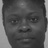

In [10]:
df_meta_sample = df_meta.sample(n=50, replace=False, random_state=42)
df_sample_file_paths = df_meta_sample["file_path"]
categories = list(df_meta_sample["category"])

sample_images = [load_img(image_path) for image_path in df_sample_file_paths]
sample_images[0]

neutral 0


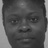

fear 1


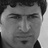

happy 2


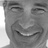

neutral 3


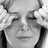

happy 4


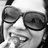

neutral 5


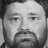

sad 6


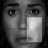

happy 7


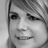

sad 8


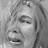

surprise 9


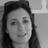

fear 10


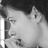

happy 11


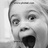

angry 12


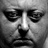

fear 13


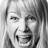

sad 14


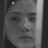

angry 15


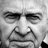

angry 16


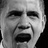

happy 17


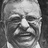

sad 18


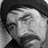

happy 19


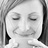

fear 20


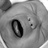

happy 21


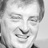

surprise 22


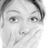

happy 23


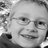

neutral 24


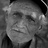

sad 25


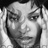

angry 26


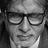

fear 27


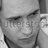

sad 28


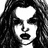

neutral 29


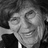

happy 30


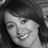

neutral 31


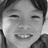

sad 32


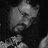

neutral 33


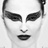

happy 34


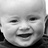

happy 35


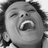

surprise 36


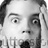

fear 37


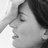

fear 38


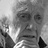

sad 39


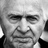

neutral 40


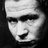

neutral 41


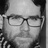

happy 42


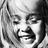

fear 43


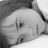

neutral 44


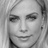

fear 45


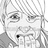

surprise 46


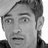

happy 47


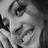

sad 48


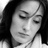

happy 49


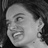

In [11]:
for i, img in enumerate(sample_images):
    print(categories[i], i)
    display(img)

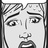

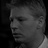

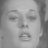

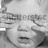

In [12]:
cartoon_image = load_img('../data/fer_2013/train/fear/Training_81764761.jpg')
dark_image = load_img('../data/fer_2013/train/sad/Training_64076435.jpg')
blurry_image = load_img('../data/fer_2013/train/sad/Training_97928372.jpg')
marked_image = load_img('../data/fer_2013/train/neutral/Training_65771354.jpg')
display(cartoon_image, dark_image,  blurry_image, marked_image)

## Class Distribution

Our training images have been categorised into 7 different emotions: 
- angry
- disgust
- fear
- happy
- neutral
- sad
- surprise

We can see that the distribution across classes is very imbalanced with over 25% of the images categorised as "happy". 

Having an imbalanced dataset can lead to models that do not generalise well to other datasets. Later on we will consider strategies for overcoming this imbalance.

In [13]:
df_meta["category"].value_counts(normalize=True)

category
happy       0.251315
neutral     0.172942
sad         0.168240
fear        0.142708
angry       0.139155
surprise    0.110453
disgust     0.015187
Name: proportion, dtype: float64

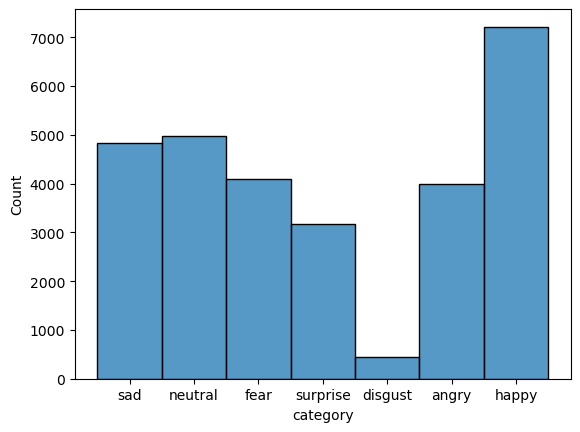

In [14]:
sns.histplot(data=df_meta, x="category")
plt.show()

## Exploring images further using meta data

We use the meta data and explore the following:

1. image resolution: all images are 48x48 pixels
2. file format and size: all are compressed JPEG files under 2.35 KB
3. data encoding: all our images are grayscale
4. quality
5. duplicates

### 1. Image resolution

All of our training data is 48 x 48 pixels. This is fairly small but since our classification task is quite simple, it is ok.

In [15]:
df_meta["dimensions"].value_counts()

dimensions
48x48    28709
Name: count, dtype: int64

### 2. File format and size

All the image files are JPEGs.

All our files are under 2.35 KB: they are compressed images.

Compressed images could mean poor quality: we have already seen from our random selection taht there is some blurring.


Smaller sizes, however, means faster training time.

In [16]:
df_meta["image_format"].value_counts()

image_format
JPEG    28709
Name: count, dtype: int64

In [17]:
df_meta["size_kb"].describe()

count    28709.000000
mean         1.537030
std          0.158096
min          0.350000
25%          1.440000
50%          1.540000
75%          1.640000
max          2.340000
Name: size_kb, dtype: float64

### 3. Data Type/Encoding

All of our data is grayscale.

In [18]:
df_meta["mode_desc"].value_counts()

mode_desc
8-bit pixels, grayscale    28709
Name: count, dtype: int64

### 4. Image quality

Noise is random variations in image data that can reduce the quality of the image. This can happen when an image is compressed. During compression, the image size is reduced by discarding some of the data. This can introduce blockiness or blurring.

**Why is this a problem for Machine Learning?**

Just like blur stops a human from being able to see an image clearly, for a machine, noise can obscure important features in an image, making it harder to distinguish between the true signal and background clutter.

**Noise score**

To identify poor images quality I created a "noise score".  This is a simple algorithm that loops through sections of each image, calculates the standard deviation for each section and sums the results to give a measure of noise.

Images with low scores are those where there is little pixel contrast e.g. a noise score of zero means that there is no contrast between pixels and in this case we can expect to see solid colours. In our dataset we have some images with this score and they are all black.

Images with high scores are those with high pixel contrast. This is when blockiness can be seen. In our dataset we observe that cartoon images fall into this category more easily.

**Visualizing the distribution of Noise score**

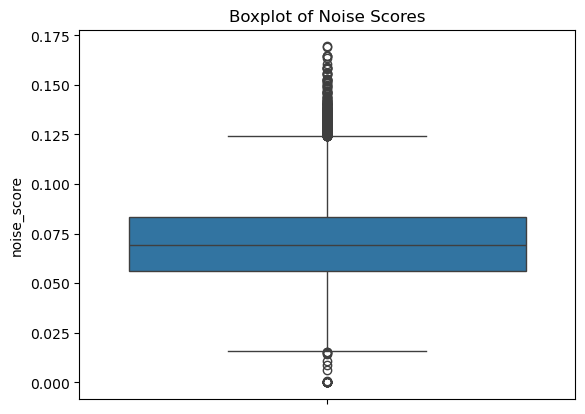

In [19]:
ax = sns.boxplot(data=df_meta["noise_score"])

plt.title('Boxplot of Noise Scores')
plt.show()

To assess what these numbers mean, we pick images within our interquartile range. We can see visually that they are OK i.e. all faces, all easy for humans to parse.

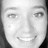

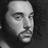

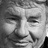

In [20]:
q1, median, q3 = np.quantile(df_meta["noise_score"], [0.25, 0.5,0.75])

q1_img_filepath = df_meta[df_meta["noise_score"] == q1]["file_path"].iloc[0]
q3_img_filepath = df_meta[df_meta["noise_score"] == q3]["file_path"].iloc[0]
median_img_filepath = df_meta[df_meta["noise_score"] == median]["file_path"].iloc[0]

load_print_images([q1_img_filepath,q3_img_filepath, median_img_filepath])

#### Outliers

The outliers have been calculated using a standard measure i.e. those images that have a lower or higher score than the lower or upper whisker. Specifically, images with a noise score < 0.015461964195994 or above 0.12411858131835993

In [21]:
iqr = q3 - q1

lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr

q1, q3, lower_whisker, upper_whisker

(np.float64(0.05620819561688122),
 np.float64(0.0833723498974727),
 np.float64(0.015461964195994),
 np.float64(0.12411858131835993))

In [22]:
noise_outliers_higher = df_meta[df_meta["noise_score"] > upper_whisker].sort_values(by="noise_score", ascending=False)
noise_outliers_lower = df_meta[df_meta["noise_score"] < lower_whisker].sort_values(by="noise_score", ascending=True)

len(noise_outliers_higher), len(noise_outliers_lower)

(317, 20)

**Low noise scores**

There are only 20 outliers with low noise scores: we see visually that they are all very dark and it is difficult to make out the image. 


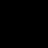

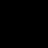

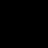

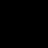

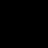

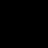

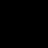

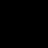

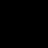

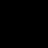

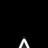

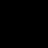

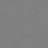

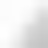

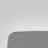

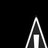

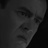

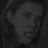

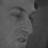

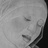

In [23]:
load_print_images(noise_outliers_lower["file_path"].iloc[:])

**High noise scores**

There are far more outliers in this category (317) than in the low noise score category. We can see that there are more cartoons in this group, which is unsurprising since cartoons are often high contrast. 

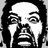

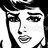

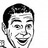

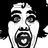

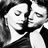

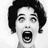

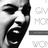

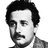

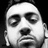

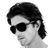

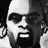

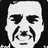

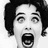

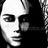

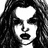

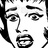

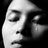

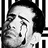

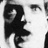

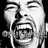

In [24]:
load_print_images(noise_outliers_higher["file_path"].iloc[:20])

### 5. Duplicates

From randomly selecting images, I have noticed that there are duplicate images in this dataset.

I have used perceptual hashing using [imagehash](https://github.com/JohannesBuchner/imagehash) to identify duplicate images. Image hashes tell whether two images look nearly identical. It doesn't look at exact pixel values so is able to pick up near identical images. We can see that most of the duplicates found have the same noise score, which is a good sign that the hashing works as expected.

We have identified 2400 duplicates. Sometimes there is more than one copy of an image so rather than having 1200 images to drop, we would drop 1314 rows.

In [25]:
df_meta[df_meta.duplicated(subset='hash_value')].sort_values(by="hash_value")

,category,file_name,file_path,size_kb,dimensions,mode_desc,image_format,noise_score,hash_value
18865,angry,Training_96772745.jpg,../data/fer_2013/train/angry/Training_96772745...,0.35,48x48,"8-bit pixels, grayscale",JPEG,0.000000,0000000000000000
19436,angry,Training_32571770.jpg,../data/fer_2013/train/angry/Training_32571770...,0.35,48x48,"8-bit pixels, grayscale",JPEG,0.000000,0000000000000000
20088,angry,Training_99531165.jpg,../data/fer_2013/train/angry/Training_99531165...,0.35,48x48,"8-bit pixels, grayscale",JPEG,0.000000,0000000000000000
14709,surprise,Training_48403842.jpg,../data/fer_2013/train/surprise/Training_48403...,0.35,48x48,"8-bit pixels, grayscale",JPEG,0.000000,0000000000000000
21365,angry,Training_28756096.jpg,../data/fer_2013/train/angry/Training_28756096...,0.35,48x48,"8-bit pixels, grayscale",JPEG,0.000000,0000000000000000
...,...,...,...,...,...,...,...,...,...
15897,surprise,Training_10227694.jpg,../data/fer_2013/train/surprise/Training_10227...,1.59,48x48,"8-bit pixels, grayscale",JPEG,0.077121,ff7d2062e16948e2
15981,surprise,Training_27766183.jpg,../data/fer_2013/train/surprise/Training_27766...,1.55,48x48,"8-bit pixels, grayscale",JPEG,0.058385,ff81ff82fa2e0022
12613,fear,Training_27746315.jpg,../data/fer_2013/train/fear/Training_27746315.jpg,1.87,48x48,"8-bit pixels, grayscale",JPEG,0.097149,ff9fe0b0d2290a45
14762,surprise,Training_63470176.jpg,../data/fer_2013/train/surprise/Training_63470...,1.68,48x48,"8-bit pixels, grayscale",JPEG,0.058649,ffa87692895c3582


In [26]:
duplicates = df_meta.groupby(['hash_value']).filter(lambda x: len(x) > 1)
duplicates_sorted_by_hash = duplicates.sort_values(by="hash_value")
duplicates_sorted_by_hash.tail()

,category,file_name,file_path,size_kb,dimensions,mode_desc,image_format,noise_score,hash_value
12613,fear,Training_27746315.jpg,../data/fer_2013/train/fear/Training_27746315.jpg,1.87,48x48,"8-bit pixels, grayscale",JPEG,0.097149,ff9fe0b0d2290a45
11535,fear,Training_49198048.jpg,../data/fer_2013/train/fear/Training_49198048.jpg,1.87,48x48,"8-bit pixels, grayscale",JPEG,0.097149,ff9fe0b0d2290a45
13284,fear,Training_70012504.jpg,../data/fer_2013/train/fear/Training_70012504.jpg,1.68,48x48,"8-bit pixels, grayscale",JPEG,0.058649,ffa87692895c3582
14762,surprise,Training_63470176.jpg,../data/fer_2013/train/surprise/Training_63470...,1.68,48x48,"8-bit pixels, grayscale",JPEG,0.058649,ffa87692895c3582
11113,fear,Training_12587825.jpg,../data/fer_2013/train/fear/Training_12587825.jpg,1.68,48x48,"8-bit pixels, grayscale",JPEG,0.058649,ffa87692895c3582


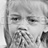

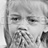

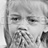

In [27]:
load_print_images(duplicates_sorted_by_hash.tail(3)["file_path"].values)

In [28]:
len(duplicates)

2400

In [29]:
duplicates_sorted_by_noise = duplicates.sort_values(by="noise_score", ascending=False)
duplicates_sorted_by_noise.head()

,category,file_name,file_path,size_kb,dimensions,mode_desc,image_format,noise_score,hash_value
20568,angry,Training_35899521.jpg,../data/fer_2013/train/angry/Training_35899521...,2.17,48x48,"8-bit pixels, grayscale",JPEG,0.149590,e747676228391b9a
19600,angry,Training_80209767.jpg,../data/fer_2013/train/angry/Training_80209767...,2.17,48x48,"8-bit pixels, grayscale",JPEG,0.149590,e747676228391b9a
15924,surprise,Training_27672614.jpg,../data/fer_2013/train/surprise/Training_27672...,2.17,48x48,"8-bit pixels, grayscale",JPEG,0.146148,9b84fed2867960d8
13904,surprise,Training_42143192.jpg,../data/fer_2013/train/surprise/Training_42143...,2.17,48x48,"8-bit pixels, grayscale",JPEG,0.146148,9b84fed2867960d8
20754,angry,Training_28028740.jpg,../data/fer_2013/train/angry/Training_28028740...,1.79,48x48,"8-bit pixels, grayscale",JPEG,0.136115,c05e27f20f787c61


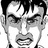

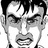

In [30]:
load_print_images(duplicates_sorted_by_noise.head(2)["file_path"].values)

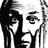

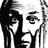

In [31]:
load_print_images(duplicates_sorted_by_noise.head()[2:4]["file_path"].values)